# 1. 重参数化技巧

一开始写错了，以为是对`eps`求导，变成了

![](demo/reparam_gradient.png)

naive grad variance: [5.74129343 1.00604956 0.17195452 0.08618732 0.01622461]
reparameterization grad variance: [0.39380306 0.03859908 0.00890374 0.00394094 0.00082136]


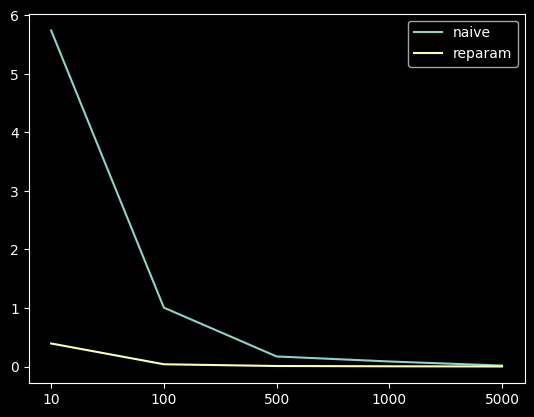

In [117]:
import numpy as np
import matplotlib.pyplot as plt
def naive_grad(x, mu):
    # the naive gradient to mu
    # \nabla_\mu \mathbb{E}_q[x^2] = \mathbb{E}_q[x^2(x-\mu)]
    return np.mean(x ** 2 * (x - mu))
    
def reparam_grad(eps, mu):
    #### You need to finish the reparameterization gradient to mu here ####
    # \nabla_\mu \mathbb{E}_q[x^2] = \mathbb{E}_q[2*(\varepsilon+\mu)]
	# return np.mean((2-eps)*(mu+eps))
    return np.mean(2*(mu+eps))
    
def main():
    data_size_list = [10, 100, 500, 1000, 5000]
    sample_num = 100
    mu, sigma = 2.0, 1.0
    # variance of the gradient to mu
    var1 = np.zeros(len(data_size_list))
    var2 = np.zeros(len(data_size_list))

    for i, data_size in enumerate(data_size_list):
        estimation1 = np.zeros(sample_num)
        estimation2 = np.zeros(sample_num)
    
        for n in range(sample_num):
            # 1.naive method
            x = np.random.normal(mu, sigma, size=(data_size, ))
            estimation1[n] = naive_grad(x, mu)
        
            # 2.reparameterization method
            eps = np.random.normal(0.0, 1.0, size=(data_size, ))
            x = eps * sigma + mu
            estimation2[n] = reparam_grad(eps, mu)
            var1[i] = np.var(estimation1)
            var2[i] = np.var(estimation2)
            
    print('naive grad variance: {}'.format(var1))
    print('reparameterization grad variance: {}'.format(var2))
    # plot figure
    index = [_ for _ in range(len(data_size_list))]
    plt.plot(index, var1)
    plt.plot(index, var2)
    plt.xticks(index, data_size_list)
    plt.legend(['naive', 'reparam'])
    plt.savefig('demo/reparam.png')
    plt.show()

if __name__ == "__main__":
    main()

# 2. 连续动作空间（小人越悬崖）

In [118]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import torch.nn.functional as F 

In [119]:
class LittleHuman(nn.Module):

    def __init__(self, lr = 0.01) -> None:
        super().__init__()

        self.lr = lr

        self.param1 = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.param2 = nn.Parameter(torch.zeros(1), requires_grad=True)
        # sigma_theta = 
        # sigma_v = 

        # 只有 torch 本身的方法才会计算计算图
        self.sigma = torch.concat([torch.exp(self.param1) * torch.pi / 2., torch.exp(self.param2) * 10.])
        self.hidden = nn.Sequential(
            nn.Linear(2, 2),
            nn.Tanh()
        )


    def _get_mu(self, x):
        x = 0.5 * (x + 1)
        x[..., 0] *= 0.5 * torch.pi
        x[..., 1] *= 10.
        
        return x

    def policy(self, d):
        x = self.hidden(d)
        mu = self._get_mu(x)
        dist = MultivariateNormal(mu, scale_tril=torch.diag(self.sigma))

        return dist
    
    def success(self, a, d) -> bool:
        theta, v = torch.split(a, 1, -1)
        vx = v * torch.cos(theta)
        vy = v * torch.cos(theta)

        d1, d2 = torch.split(a, 1, -1)
        t = d1 / vx
        return vy*t - 0.5*9.8*t*t >= d2

    def reward(self, action, success):
        v = action[...,-1]
        return success * (100 - v**2)

    def update(self, reward, prob):
        
        # print(reward * prob)
        (reward * prob).mean().backward()
        # print(self.param1.grad)

        with torch.no_grad():
            self.param1 += self.lr *  self.param1.grad
            self.param2 += self.lr * self.param2.grad

        print(self.hidden[0].weight.grad, self.hidden[0].bias.grad)
        print(self.param1.grad, self.param2.grad)

    def run(self, d):
        dist = self.policy(d)
        action = dist.sample()
        success = self.success(action, d)
        with torch.no_grad():
            reward = self.reward(action, success)
        prob = dist.log_prob(action)
        grad = self.update(reward, prob)


In [120]:
lm = LittleHuman()
lm.train()
lm.run(torch.tensor([[[0.2, 0.2]]]))

tensor([[0., 0.],
        [0., 0.]]) tensor([0., 0.])
tensor([0.]) tensor([0.])


# 题⽬3（应⽤实践）
在课程第⼆讲（解构复杂动作空间）⼏个应⽤中任选⼀个

- ⽕箭回收（离散动作空间）
- ⽆⼈机姿态控制（连续动作空间）
- 导航控制（混合动作空间）

根据课程组给出的⽰例代码，训练得到相应的智能体。最终提交需要上传相关训练代码、⽇志截图或
最终所得的智能体效果视频（replay），具体样式可以参考第⼆讲的⽰例ISSUE。

In [ ]:
# Please install latest DI-engine's main branch first
# And we will release DI-engine v0.4.6 version with stable and tuned configuration of these demos.
from ding.bonus import PPOF


def lunarlander_discrete():
    # Please install lunarlander env first, `pip3 install box2d`
    agent = PPOF(env='lunarlander_discrete', exp_name='./lunarlander_discrete_demo')
    agent.train(step=int(1e5))
    # Classic RL interaction loop and save replay video
    agent.deploy(enable_save_replay=True)


def lunarlander_continuous():
    # Please install lunarlander env first, `pip3 install box2d`
    agent = PPOF(env='lunarlander_continuous', exp_name='./lunarlander_continuous_demo', seed=314)
    agent.train(step=int(1e5))
    # Batch (Vectorized) evaluation
    agent.batch_evaluate(env_num=4, n_evaluator_episode=8)


def rocket_landing():
    # Please install rocket env first, `pip3 install git+https://github.com/nighood/rocket-recycling@master#egg=rocket_recycling`
    agent = PPOF(env='rocket_landing', exp_name='./rocket_landing_demo')
    agent.train(step=int(5e6), context='spawn')


def drone_fly():
    # Please install gym_pybullet_drones env first, `pip3 install git+https://github.com/zjowowen/gym-pybullet-drones@master`
    agent = PPOF(env='drone_fly', exp_name='./drone_fly_demo')
    agent.train(step=int(5e6))


def hybrid_moving():
    # Please install gym_hybrid env first, refer to the doc `https://di-engine-docs.readthedocs.io/zh_CN/latest/13_envs/gym_hybrid_zh.html`
    agent = PPOF(env='hybrid_moving', exp_name='./hybrid_moving_demo')
    agent.train(step=int(5e6))


if __name__ == "__main__":
    # You can select and run your favorite demo
    # lunarlander_discrete()
    # lunarlander_continuous()
    # rocket_landing()
    # drone_fly()
    hybrid_moving()